In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import copy
from sklearn import preprocessing
from vardata import years, team_abbr, columns, teams_idx
from results_processor import *

In [2]:
# read in data csv to df
df = pd.read_csv('stats/final_data.csv', index_col=[0])

In [3]:
# preview the data to ensure it was read correctly
print('Dimension of dataset= ', df.shape)
df.head() # To get first n rows from the dataset default value of n is 5

Dimension of dataset=  (3359, 75)


home_team away_team  ht_points_for  ht_yards  ht_plays  ht_yards_per_play  \
0       nor       min          366.0    5481.0    1022.0               5.35   
1       pit       atl          331.5    5422.0     975.0               5.60   
2       buf       mia          308.0    4913.5     971.0               5.05   
3       chi       det          351.5    5064.0     970.5               5.20   
4       nwe       cin          456.5    5566.0     971.5               5.75   

   ht_turnovers  ht_fumbles_lost  ht_first_downs  ht_completions  ...  \
0          28.5             10.0           313.5           391.5  ...   
1          24.5              9.0           289.5           331.0  ...   
2          29.0             13.0           263.5           292.0  ...   
3          30.0             12.5           291.5           303.0  ...   
4          18.0              7.5           312.5           328.5  ...   

   at_4D_conversions  at_4D_conversion_percentage  at_red_zone_attempts  \
0               11.5                        56.15                  45.5   
1               10.5                        67.90                  49.0   
2                5.0                        50.00                  44.0   
3                8.0                        54.35                  43.5   
4               12.5                        64.20                  52.5   

   at_red_zone_tds  at_red_zone_td_percentage  ht_score  at_score  \
0             20.0                      43.95        14         9   
1             25.5                      50.15        15         9   
2             25.5                      57.00        10        15   
3             24.5                      56.00        19        14   
4             27.0                      51.55        38        24   

   total_points  ht_pts_diff  ht_vegas_line  
0            23            5           -5.0  
1            24            6            1.5  
2            25           -5            3.0  
3            33            5           -6.5  
4            62           14           -5.5  

[5 rows x 75 columns]

In [4]:
X = df.values[:, 2:70]  # get input values from first two columns
y = df.values[:, [73]]  # get output values from last coulmn
m = len(y) # Number of training examples

In [5]:
# preview the data
print('Total no of samples (m) = %s \n' %(m))

# Show only first 5 records
for i in range(5):
    print('X =', X[i, ], ', y =', y[i])

Total no of samples (m) = 3359 

X = [366.0 5481.0 1022.0 5.35 28.5 10.0 313.5 391.5 595.0 3904.0 29.0 18.5
 6.25 207.0 398.5 1577.0 9.5 3.95 90.5 94.0 835.0 16.0 179.0 33.65 14.6
 294.0 4969.5 965.0 5.15 31.0 13.5 281.0 305.5 499.5 3100.0 13.5 17.5
 5.800000000000001 154.5 431.0 1869.5 14.5 4.35 99.0 94.0 735.0 27.5 181.0
 28.35 15.85 215.0 96.5 44.8 10.5 5.0 47.75 53.5 28.5 53.65 204.0 70.5
 34.55 20.0 11.5 56.150000000000006 45.5 20.0 43.95] , y = [5]
X = [331.5 5422.0 975.0 5.6 24.5 9.0 289.5 331.0 519.5 3613.0 22.5 15.5 6.5
 179.0 418.5 1809.0 12.0 4.35 96.5 108.0 953.0 14.0 179.5 31.5 12.8 323.0
 4943.5 1035.5 4.75 26.0 11.0 312.5 362.0 585.0 3496.0 21.5 15.0 5.6 191.0
 415.0 1447.5 9.5 3.4 86.0 72.0 657.0 35.5 178.5 32.5 13.15 209.5 86.5
 41.2 11.0 5.5 46.45 46.0 23.5 51.4 224.5 91.0 40.1 15.5 10.5 67.9 49.0
 25.5 50.15] , y = [6]
X = [308.0 4913.5 971.0 5.05 29.0 13.0 263.5 292.0 510.5 3253.0 23.0 16.0 5.95
 166.0 424.0 1660.5 7.0 3.95 83.0 83.5 681.5 14.5 181.5 28.4 14.55 349.

In [6]:
# split data into train, validation, and test sets
# 8 years of data for training, 2 for validation and 3 for testing
X_train = X[:2048].astype('float32')
X_val = X[2048:2560].astype('float32')
X_test = X[2560:].astype('float32')
y_train = y[:2048].astype('float32')
y_val = y[2048:2560].astype('float32')
y_test = y[2560:].astype('float32')

In [7]:
# data preprocessing
scaler = preprocessing.MinMaxScaler().fit(X_train)
X_scaled_train = scaler.transform(X_train)
X_scaled_val = scaler.transform(X_val)
X_scaled_test = scaler.transform(X_test)

In [8]:
# custom class to create datasets from given data
class dataset(Dataset):
  def __init__(self, input, pred):
    self.input = torch.tensor(input,dtype=torch.float32)
    self.pred = torch.tensor(pred,dtype=torch.long)
    self.length = len(self.pred)
  def __getitem__(self,idx):
    return self.input[idx], self.pred[idx]
  def __len__(self):
    return self.length

In [9]:
# class to create feed forward neural net
# takes as inputs input_size, hidden_size, num_layers, and desired activation function
class NFLPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, activation):
        super(NFLPredictor, self).__init__()
        self.num_layers = num_layers
        self.activation = activation
        # input layer
        self.fc1 = nn.Linear(input_size, hidden_size)
        # activation functions
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        # hidden layer
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        # output layer
        self.fc3 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # tanh activation function
        if self.activation == 'tanh':
            # first layer
            out = self.fc1(x)
            out = self.tanh(out)
            
            # loop through input number of layers
            for i in range(self.num_layers - 1):
                out = self.fc2(out)
                out = self.tanh(out)
            
            out = self.fc3(out)
            return out
        
        # relu activation function
        elif self.activation == 'relu':
            # first layer
            out = self.fc1(x)
            out = self.relu(out)
            
            # loop through input number of layers
            for i in range(self.num_layers - 1):
                out = self.fc2(out)
                out = self.relu(out)
            
            out = self.fc3(out)
            return out
        
        # sigmoid activation function
        elif self.activation == 'sigmoid':
            # first layer
            out = self.fc1(x)
            out = self.sigmoid(out)
            
            # loop through input number of layers
            for i in range(self.num_layers - 1):
                out = self.fc2(out)
                out = self.sigmoid(out)
            
            out = self.fc3(out)
            return out

In [10]:
# function used to train models
# takes as input the defined model and number of epochs 
def train_model(net, num_epochs, train_loader, validation_loader):
    best_val_loss = float('inf')
    train_losses = []
    val_losses= []
    train_size = len(train_loader.dataset)
    val_size = len(validation_loader.dataset)

    for epoch in range(num_epochs):
        net.train()
        train_loss = 0
        train_acc = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = net(batch_X)
            loss = criterion(outputs, batch_y.float())
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * batch_X.shape[0]
        train_loss /= train_size
        train_losses.append(train_loss)

        net.eval()
        val_loss = 0
        val_acc = 0
        with torch.no_grad():
            for batch_X, batch_y in validation_loader:
                outputs = net(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item() * batch_X.shape[0]
            val_loss /= val_size
            val_losses.append(val_loss)

            # update best validation loss and associated model if appropriate
            if val_loss < best_val_loss:
                best_model_state = copy.deepcopy(net.state_dict())
                best_val_loss = val_loss
        
        print(f'Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
        
    return(best_model_state, train_losses, val_losses)

In [11]:
# create datasets from data
test_set = dataset(X_scaled_test, y_test)
train_set = dataset(X_scaled_train, y_train)
validation_set = dataset(X_scaled_val, y_val)

In [12]:
# create dataloaders for each set of data
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, shuffle=False)
val_loader = DataLoader(validation_set, batch_size=32, shuffle=False)

In [13]:
# model
net = NFLPredictor(X_test.shape[1], 68, 1, 'tanh')

# loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001)

num_epochs = 100

In [14]:
# train the model
best_model_state, train_losses, val_losses = train_model(net, num_epochs, train_loader, val_loader)

Epoch 1/100: Train Loss: 216.3851, Train Acc: 0.0000, Val Loss: 210.8680, Val Acc: 0.0000
Epoch 2/100: Train Loss: 209.2312, Train Acc: 0.0000, Val Loss: 204.5615, Val Acc: 0.0000
Epoch 3/100: Train Loss: 198.5256, Train Acc: 0.0000, Val Loss: 189.6115, Val Acc: 0.0000
Epoch 4/100: Train Loss: 181.5557, Train Acc: 0.0000, Val Loss: 166.4626, Val Acc: 0.0000
Epoch 5/100: Train Loss: 164.8019, Train Acc: 0.0000, Val Loss: 153.3583, Val Acc: 0.0000
Epoch 6/100: Train Loss: 155.0200, Train Acc: 0.0000, Val Loss: 148.1335, Val Acc: 0.0000
Epoch 7/100: Train Loss: 151.2328, Train Acc: 0.0000, Val Loss: 145.6061, Val Acc: 0.0000
Epoch 8/100: Train Loss: 150.0985, Train Acc: 0.0000, Val Loss: 149.0610, Val Acc: 0.0000
Epoch 9/100: Train Loss: 149.8001, Train Acc: 0.0000, Val Loss: 144.5970, Val Acc: 0.0000
Epoch 10/100: Train Loss: 148.8535, Train Acc: 0.0000, Val Loss: 154.7853, Val Acc: 0.0000
Epoch 11/100: Train Loss: 148.3998, Train Acc: 0.0000, Val Loss: 153.0353, Val Acc: 0.0000
Epoch 12

Epoch 96/100: Train Loss: 143.9678, Train Acc: 0.0000, Val Loss: 145.9079, Val Acc: 0.0000
Epoch 97/100: Train Loss: 143.8839, Train Acc: 0.0000, Val Loss: 145.9177, Val Acc: 0.0000
Epoch 98/100: Train Loss: 144.0482, Train Acc: 0.0000, Val Loss: 147.9329, Val Acc: 0.0000
Epoch 99/100: Train Loss: 144.3100, Train Acc: 0.0000, Val Loss: 147.5628, Val Acc: 0.0000
Epoch 100/100: Train Loss: 144.2591, Train Acc: 0.0000, Val Loss: 152.0926, Val Acc: 0.0000


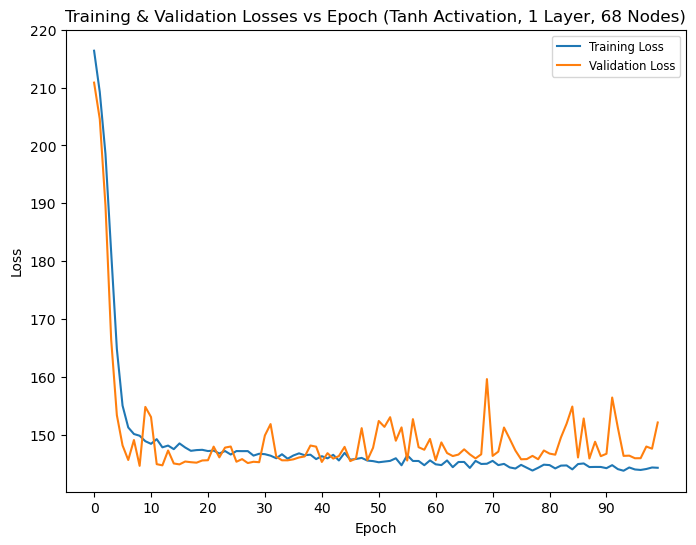

In [24]:
# plot losses with respect to epoch
plt.figure(figsize=(8,6))
plt.title('Training & Validation Losses vs Epoch (Tanh Activation, 1 Layer, 68 Nodes)')
plt.plot(train_losses, label = "Training Loss")
plt.plot(val_losses, label = "Validation Loss")

plt.xticks(range(0, num_epochs, 10))
plt.xlabel("Epoch")
plt.ylabel("Loss")
# insert a legend
plt.legend(
    loc="upper right",
    fontsize="small")

In [16]:
# load best model
net.load_state_dict(best_model_state)

<All keys matched successfully>

In [17]:
results = np.array([])
with torch.no_grad():
    for X, Y in test_loader:
        pred = net(X)
        #results.append(pred.data[0][0].item())
        results = np.append(results, [pred.data[0][0].item()])

In [18]:
results_df = pd.DataFrame(columns = ['ht_pts_diff', 'ht_vegas_line', 'model_pred'])
results_df['ht_pts_diff'] = df['ht_pts_diff'][2560:]
results_df['ht_vegas_line'] = df['ht_vegas_line'][2560:]
results_df = results_df.reset_index(drop = True)
results_df['model_pred'] = results.tolist()

In [19]:
results_df.to_csv('results/neural_net_results.csv')

In [20]:
new_train_loader = DataLoader(train_set, shuffle=False)
train_results = np.array([])
with torch.no_grad():
    for X, Y in new_train_loader:
        pred = net(X)
        #results.append(pred.data[0][0].item())
        train_results = np.append(train_results, [pred.data[0][0].item()])

In [21]:
train_results_df = pd.DataFrame(columns = ['ht_pts_diff', 'ht_vegas_line', 'model_pred'])
train_results_df['ht_pts_diff'] = df['ht_pts_diff'][:2048]
train_results_df['ht_vegas_line'] = df['ht_vegas_line'][:2048]
train_results_df = train_results_df.reset_index(drop = True)
train_results_df['model_pred'] = train_results.tolist()

*************************************************************
**The following are the results of the model on Training Data:**
*************************************************************

In [22]:
process_results(train_results_df)

Total Number of Games:
 2048
Winning Bets Count:
 1236
No Bet Placed Count:
 72
Winning Percentage:
 0.6255
______________________________________
Winner Correctly Predicted Count:
 1471
Accuracy in Classifaction:
 0.7183
______________________________________
Mean Squared Error of Results:
 148.5727
Root Mean Squared Error of Results:
 12.1890


*************************************************************
**The following are the results of the model on Testing Data:**
*************************************************************

In [23]:
process_results(results_df)

Total Number of Games:
 799
Winning Bets Count:
 477
No Bet Placed Count:
 33
Winning Percentage:
 0.6227
______________________________________
Winner Correctly Predicted Count:
 556
Accuracy in Classifaction:
 0.6959
______________________________________
Mean Squared Error of Results:
 137.7386
Root Mean Squared Error of Results:
 11.7362
